# Old notebook

This notebook has content that is no longer part of the main branch of development of the project, although it still has code sections that may be useful in the future. For this reason, it is saved in a sub-folder of archived noetbooks.

## Libraries

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# Project library
import research_project_name as project

## Parameters

In [2]:
dataroot = "../datasets"
runroot = "../run"
image_size = 64
num_channels = 3
batch_size = 64
nf = 5
nz = 10

In [3]:
saveroot = project.storage.directory.get_subdirectory_by_time(runroot)
print(saveroot)

project.storage.directory.setup(saveroot)

/Users/cesar.salcedo/Desktop/2021-03-14_10-04-10


## Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape: torch.Size([64, 3, 64, 64])


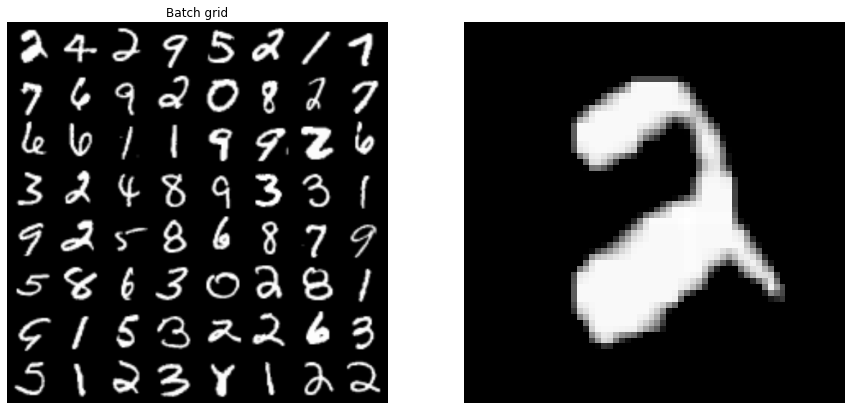

In [4]:
dataset = project.data.image.load_dataset(dataroot, "mnist", image_size, num_channels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

batch = next(iter(dataloader))[0]

print("Batch shape: {}".format(batch.shape))

fig = plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
project.plot.image.plot_grid_from_batch(batch, title="Batch grid")

plt.subplot(1, 2, 2)
project.plot.image.plot_sample(batch[0])

plt.show()
plt.close(fig)

In [5]:
def plot_two_samples(batch):
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    project.plot.image.plot_sample(batch[0])
    
    plt.subplot(1, 2, 2)
    project.plot.image.plot_sample(batch[1])
    
    return fig

In [6]:
plot_two_digits = project.plot.plotter.Plotter(saveroot, "two_digits", plot_two_samples, add_id=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


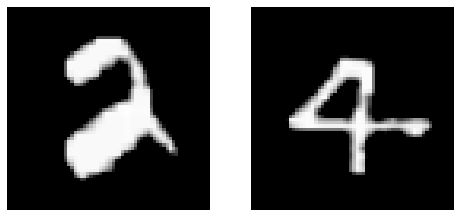

In [7]:
with plot_two_digits.plot(batch):
    plot_two_digits.save()
    plot_two_digits.show()

In [8]:
class Encoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Encoder, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(nc, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf * 2, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf * 4, nf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf * 8, nz, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [9]:
encoder = Encoder(num_channels, nf, nz)
print(encoder)

Encoder(
  (main): Sequential(
    (0): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(5, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(10, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(20, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(40, 10, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
class Decoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Decoder, self).__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, nf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(nf * 8, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(nf * 4, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(nf * 2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(nf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

In [11]:
decoder = Decoder(num_channels, nf, nz)
print(decoder)

Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(10, 40, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(40, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(20, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(10, 5, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(5, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 64, 64])


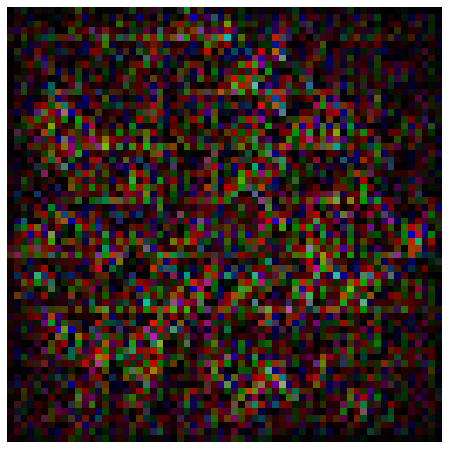

In [12]:
with torch.no_grad():
    noise = torch.randn(batch_size, nz, 1, 1)
    
    samples = decoder(noise)
    
    print(samples.shape)
    
    fig = plt.figure(figsize=(8, 8))
    plt.title("Sample image from raw decoder")
    project.plot.image.plot_sample(samples[0])
    
    project.storage.plot.save_plot(saveroot, "raw_encoder_sample")
    
    plt.show()
    plt.close(fig)

In [13]:
project.storage.model.save_model(saveroot, "decoder", decoder)

In [14]:
saved_decoder = Decoder(num_channels, nf, nz)

project.storage.model.load_last_model(saveroot, "decoder", saved_decoder)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 64, 64])


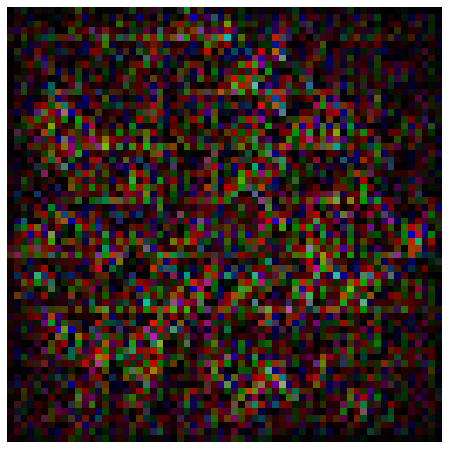

In [15]:
with torch.no_grad():
    samples = saved_decoder(noise)
    
    print(samples.shape)
    
    fig = plt.figure(figsize=(8, 8))
    plt.title("Sample image from raw decoder")
    project.plot.image.plot_sample(samples[0])
    
    project.storage.plot.save_plot(saveroot, "raw_encoder_sample")
    
    plt.show()
    plt.close(fig)